In [1]:
# Import all Libraries

import os
import re
import pandas as pd
from scipy.signal import get_window
import numpy as np
from tqdm import tqdm
import random
import enum
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from python_speech_features import mfcc,logfbank,delta
from python_speech_features.sigproc import framesig
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors
import soundfile as sf
import librosa as lb

import sys
#sys.path.insert(1, '/content/drive/My Drive/Environmental')
import stft,dft

sns.set(style="darkgrid", color_codes=True)

In [2]:
path=os.getcwd()
dataset='\\ESC-10\\'
clean_path='\\Clean Files\\'
#path='/content/drive/My Drive/Environmental'
os.listdir(path+dataset)

['001 - Dog bark',
 '002 - Rain',
 '003 - Sea waves',
 '004 - Baby cry',
 '005 - Clock tick',
 '006 - Person sneeze',
 '007 - Helicopter',
 '008 - Chainsaw',
 '009 - Rooster',
 '010 - Fire crackling',
 'ESC-10-HumanClassification.xlsx',
 'ESC-10.png',
 'README.md',
 'README.txt']

### 1.1 Setting up the Audio Files

We have 400 files distributed among 10 classes. There is one folder for each class. To manage the files we put all the filenames and their corresponding labels in a dataframe.<br> 

In [3]:
# Create String Equivalents for each of the 10 labels

my_labels={1:'Dog',2:'Rain',3:'Waves',4:'Baby',
           5:'Clock',6:'Sneeze',7:'Helicopter',8:'Chainsaw',
           9:'Rooster',10:'Fire'}

# Make a List of all Input Audio Files

data_path=path+dataset
data_folders=[data_path+i for i in os.listdir(data_path) if os.path.isfile(data_path+i)==False]
audio_files=[]
labels=[]
for i in data_folders:
    [audio_files.append(i+'/'+k) for k in os.listdir(i)]
    [labels.append(int(re.findall('0\d\d',i)[0])) for k in os.listdir(i)]
    
# Create the dataframe with filenames and Labels
df=pd.DataFrame(list(zip(audio_files,labels)),columns=['Files','Labels'])
df['Class']=df['Labels'].apply(lambda x:my_labels[x])

Each file has a prefix 1 to 5 , representing which fold it belongs to. In this case we use folds 1-4 for building a training set and the 5th fold for building the validation dataset. So we use the file name prefix to create a column Test_Val with values __Test__ and __Val__.

In [4]:
df['Test_Val']=df['Files'].apply(lambda x:'Val' if x.split('/')[-1][0]=='5' else 'Test')
df.head()

,Files,Labels,Class,Test_Val
0,C:\Users\Arindam\Documents\Up_Grad\Research\ES...,1,Dog,Test
1,C:\Users\Arindam\Documents\Up_Grad\Research\ES...,1,Dog,Test
2,C:\Users\Arindam\Documents\Up_Grad\Research\ES...,1,Dog,Test
3,C:\Users\Arindam\Documents\Up_Grad\Research\ES...,1,Dog,Test
4,C:\Users\Arindam\Documents\Up_Grad\Research\ES...,1,Dog,Test


At this stage the dataframe has the file names, Integer Labels, Class Names and Test_Val. We can randomly view a sample for each class. The list __random_clips__ is made of 10 tuples. Each tuple has a class file and a label.

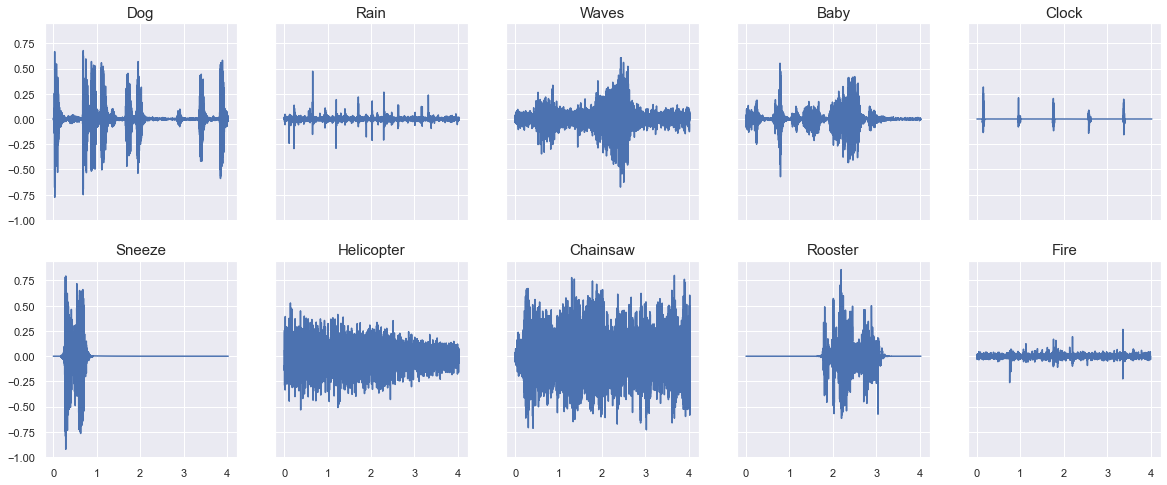

In [5]:
my_labels=df['Class'].unique()
random_clips=[]
for label in my_labels:
    sample_df=df[df['Class']==label].sample()
    random_clips.append((sample_df.iloc[0,0],label))
    

fig1, ax1= plt.subplots(2,5,figsize=(20,8),sharey=True,sharex=True)
clip=0

for ro in [0,1]:
    for col in [0,1,2,3,4]:
        signal, rate = lb.load(random_clips[clip][0],sr=44100)
        
        clip_duration=int(len(signal)/rate)
        clip_length=len(signal)
        
        ax1[ro,col].set_xticks(np.linspace(0,clip_length,clip_duration+1))
        ax1[ro,col].set_xticklabels(np.arange(clip_duration+1))
        
        ax1[ro,col].set_title(random_clips[clip][1],fontsize=15)
        sns.lineplot(x=np.arange(0,len(signal),50),y=signal[::50],ax=ax1[ro,col])
        clip+=1

## 1.2 Masking Silent Parts

The diversity in audio clips is immediately obvious. While some clips have information throughout the entire duration, some have practically none. A prominent example would be the __sneeze__ class.<br> We need to get rid of these silent parts,as they are useless in terms of informtion. We take the example of the __sneeze__ class and prepare a mask.

We use the pandas rolling function to calculate a rolling average of the signal over a moving window. The window size is one-tenth of the sample-rate. Thus we will have a sequence of means for every one-tenth of the clip. We can compare this mean against a threshold. 

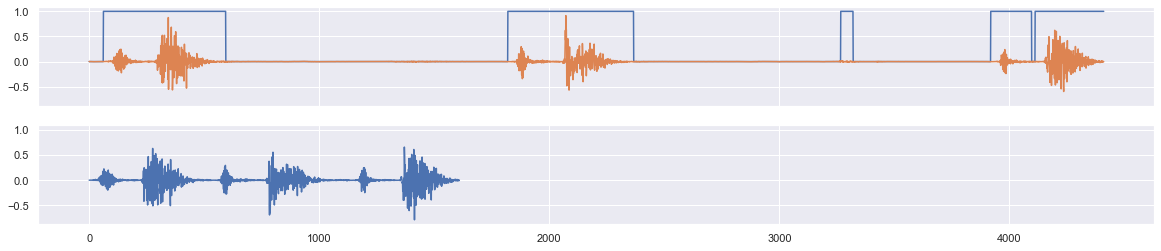

In [6]:
#one_sample='/content/drive/My Drive/Environmental/ESC-10/006 - Person sneeze/4-156844-A.ogg'
one_sample=path+'/ESC-10/006 - Person sneeze/4-156844-A.ogg'
signal, rate = lb.load(one_sample,sr=44100)
y=pd.Series(signal).apply(np.abs)
y_mean=y.rolling(window=int(rate/10),min_periods=1,center=True).mean()

mask=[]
for mean in y_mean:
        if mean>0.003:
            mask.append(1)
        else:
            mask.append(0)

masked_signal=mask*signal
masked_signal=masked_signal[masked_signal!=0]

fig2, ax2= plt.subplots(2,1,figsize=(20,4),sharey=True,sharex=True)
sns.lineplot(x=np.arange(0,len(mask[::50])),y=mask[::50],ax=ax2[0])
sns.lineplot(x=np.arange(0,len(signal[::50])),y=signal[::50],ax=ax2[0])

sns.lineplot(x=np.arange(0,len(masked_signal[::50])),y=masked_signal[::50],ax=ax2[1])


## 1.3 Setting up Pre-processing Hyperparameters

- Segment Size __25ms__
- Segment Size in Samples __M__ and __Ms__ in mili-seconds
- Sample rate __44100Hz__
- Hop Size in sample __H__ and __Hs__ in miliseconds


In [7]:
# Pre processing Hyper-parameters

sample_rate=44100                                           # Sample Rate
Ms=25/1000                                                  # Segment size , in milli-seconds in numerator
M=int(Ms*sample_rate)                                       # Size of the segment in samples

Hs=Ms/2                                                     # Hop size in mili-second
H=M//2                                                      # Hop-length in samples
N=1024                                                      # FFT Size
w=get_window('hanning',M)                                   # Choose Window

## 1.4 Cleaning the Clips

We can see that some of the audio clips have plenty of silence periods. Especially the __Sneeze__ class, has a momentary presence of data , then all goes quite. We need to clean these clips , so that the silence periods are removed.<br>
We choose a threshold of 0.003 for training and 0.03 for validation sets

__Execute only for removal of the Clean Files__

clean_files=[path+clean_path+'\\'+i for i in os.listdir(path+clean_path)]
for i in clean_files:
    os.remove(i)

The 4 functions __envelop, clean_file, clean_file_name and clean_file_duration__ acheive the following.<br>

- __envelop__ accepts a numpy array and returns a mask based on a threshold.
- __clean_file__ accepts a audio file and applies the envelop function.
- __clean_file_name__ extracts the file name from the absolute path name from the __File__ column of the dataframe.
- __clean_file_duration__ adds a column to the dataframe with the duration of the cleaned file.

In [8]:
def envelop(y,rate,threshold):
    mask=[]
    y=pd.Series(y).apply(np.abs)
    y_mean=y.rolling(window=int(rate/10),min_periods=1,center=True).mean()
    for mean in y_mean:
        if mean>threshold:
            mask.append(True)
        else:
            mask.append(False)
    return mask

def clean_file(row):
    filename=row['Files'].split('/')[-1]
    #filename=re.split('/',row['Files'])[-1]
    signal, rate = sf.read(row['Files'])
    
    # Choose appropriate Threshold Here 
    if row['Test_Val']=='Test':
        mask=envelop(signal,rate,0.003)
    else:
        mask=envelop(signal,rate,0.03)
    
    signal=signal[mask]
    sf.write(path+clean_path+filename, signal, rate)
        
    return filename

def clean_file_name(row):
    filename=row['Files'].split('/')[-1]
    return filename

def clean_file_duration(row):
    
    clean_file=path+clean_path+row['Clean File']
    signal, rate = sf.read(clean_file)
    
    return (len(signal)/rate)
                                

We now start reading each of the audio file , clean them and put in the folder __Clean Files__. If the folder is empty , it creates the clean files. If the folder is not empty, then we only need to create a column __Clean File__ to hold the file names.

In [9]:
#clean_path=path+'/Clean Files'
if len(os.listdir(path+clean_path))==0:
    df['Clean File']=df.apply(clean_file,axis=1)
    #df['Test_Val']=df['Clean File'].apply(lambda x:'Val' if x[0]=='5' else 'Test')
    #zip(*df_test['size'].apply(sizes))
else:
    df['Clean File']=df['Files'].apply(lambda x:re.split('/',x)[-1])

We subtract 1 from each label to have the calss labels from 0-9 instead of 1-10.

In [10]:
df['Duration']=df.apply(clean_file_duration,axis=1)
df['Labels']=df['Labels'].apply(lambda x:x-1)
df=df[df['Duration']>0.2]
df

,Files,Labels,Class,Test_Val,Clean File,Duration
0,C:\Users\Arindam\Documents\Up_Grad\Research\ES...,0,Dog,Test,1-100032-A.ogg,0.330227
1,C:\Users\Arindam\Documents\Up_Grad\Research\ES...,0,Dog,Test,1-110389-A.ogg,0.407755
2,C:\Users\Arindam\Documents\Up_Grad\Research\ES...,0,Dog,Test,1-30226-A.ogg,4.791837
3,C:\Users\Arindam\Documents\Up_Grad\Research\ES...,0,Dog,Test,1-30344-A.ogg,2.749773
4,C:\Users\Arindam\Documents\Up_Grad\Research\ES...,0,Dog,Test,1-32318-A.ogg,3.281179
...,...,...,...,...,...,...
392,C:\Users\Arindam\Documents\Up_Grad\Research\ES...,9,Fire,Val,5-186924-A.ogg,5.000998
393,C:\Users\Arindam\Documents\Up_Grad\Research\ES...,9,Fire,Val,5-189212-A.ogg,3.157256
397,C:\Users\Arindam\Documents\Up_Grad\Research\ES...,9,Fire,Val,5-213802-A.ogg,5.000998
398,C:\Users\Arindam\Documents\Up_Grad\Research\ES...,9,Fire,Val,5-215658-A.ogg,2.571655


We can now visualize the cleaned version of the audio clips, with silent periods removed.

In [11]:
random_clips_cleaned=[]

for file in random_clips:
    orig_file=file[0]
    label=file[1]
    
    clean_file_name=df[df['Files']==orig_file]['Clean File'].tolist()[0]
    clean_file=path+clean_path+clean_file_name
    random_clips_cleaned.append((clean_file,label))

In [12]:
random_clips_cleaned=[]

for file in random_clips:
    orig_file=file[0]
    label=file[1]
    
    if df[df['Files']==orig_file].shape[0]!=0:
        clean_file_name=df[df['Files']==orig_file]['Clean File'].tolist()[0]
        clean_file=path+clean_path+clean_file_name
    else:
        clean_file='File Removed'
    random_clips_cleaned.append((clean_file,label))

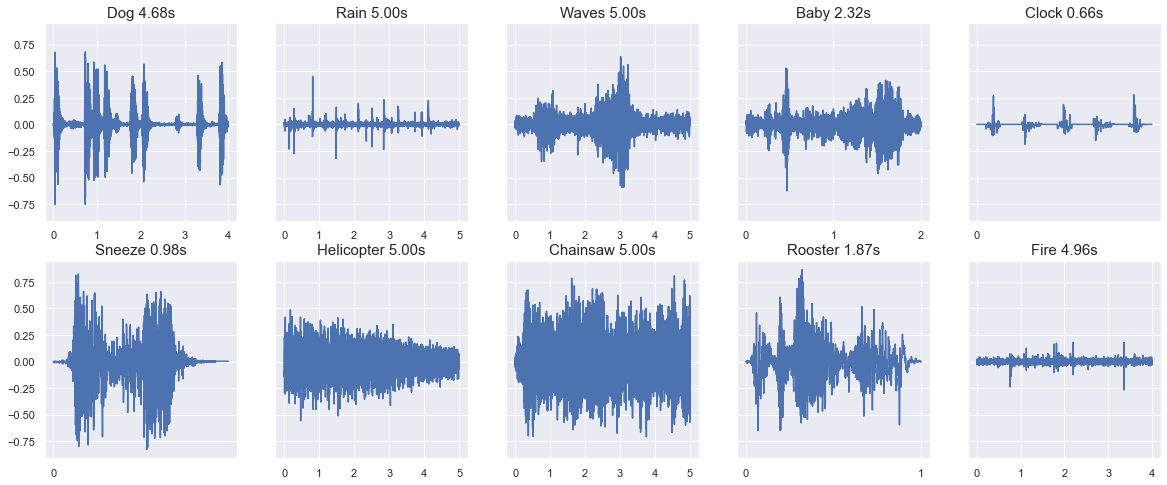

In [13]:
fig3, ax3= plt.subplots(2,5,figsize=(20,8),sharey=True)
clip=0

for ro in [0,1]:
    for col in [0,1,2,3,4]:
        signal, rate = sf.read(random_clips_cleaned[clip][0])
        
        clip_duration=int(len(signal)/rate)
        clip_length=len(signal)
        #print(len(signal)/rate)        
        ax3[ro,col].set_xticks(np.linspace(0,clip_length,clip_duration+1))
        ax3[ro,col].set_xticklabels(np.arange(clip_duration+1))
        
        ax3[ro,col].set_title(random_clips[clip][1]+' '+str('{:0.2f}'.format(len(signal)/rate))+'s',fontsize=15)
        sns.lineplot(x=np.arange(0,len(signal),50),y=signal[::50],ax=ax3[ro,col])
        clip+=1

One problem we immediately notice that the clips with prolonged silent periods are shortened. This explains the unequal clip-length after cleaning the audio clips.

In [14]:
df.to_csv(path+'\\Cleaned data thd 03.csv',index=False)

# 1.3 Visualizing the Data

We now visualize this audio clips by using STFT __( Short Term Fourier Transform )__. Despite the unequal clip durations, we break each clip into frames, called segments.<br>

The list __random_clips_cleaned__ has 1 file each from each class picked randomly. We apply these pre-processing parameters to calculate the 512 FFT of each these segment. The number of available segments is shown at the top of each sub-plot.

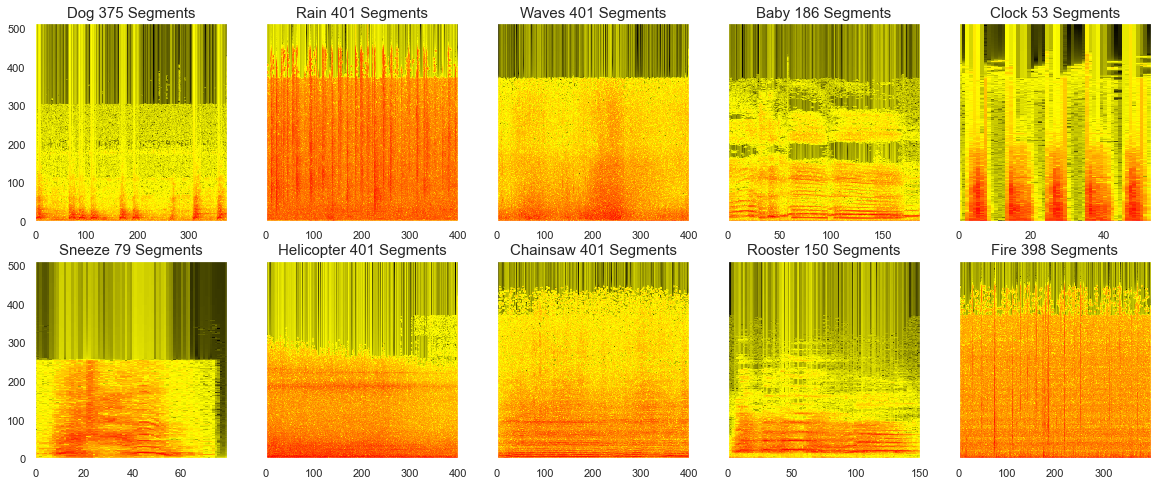

In [15]:
fig4, ax4= plt.subplots(2,5,figsize=(20,8),sharey=True)

clip=0

cvals  = [-1, 0, 1]
colors = ["black","yellow","red"]

norm=plt.Normalize(min(cvals),max(cvals))
tuples = list(zip(map(norm,cvals), colors))
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", tuples)

for ro in [0,1]:
    for col in [0,1,2,3,4]:
        
        signal, samplerate = sf.read(random_clips_cleaned[clip][0])
        clip_duration=int(len(signal)/samplerate)
        clip_length=len(signal)
        mX,pX,n=stft.stftAnal(signal,w,N,H)
        
        num_frames=len(mX)
        
        ax4[ro,col].set_title(random_clips[clip][1]+' '+str(num_frames)+' Segments',fontsize=15)
        ax4[ro,col].pcolormesh(mX.T,cmap=cmap)
        
        clip+=1

# 1.5 MFCC from STFT

This is the most important part of the feature extraction using a single function. To calculate the MFCC we use the default settings of the __python_speech_features__ library. They are as follows.<br>

- Sampling Rate 16000
- Segment Size M=25ms ( 400 samples )
- Hop Size L=10ms ( 160 Samples )

This generates a 13 feature vector for every 25ms segment. Every segment has an overlap with the previous segment. For visualization , we only do this operation for the entire audip files we have selected at random.

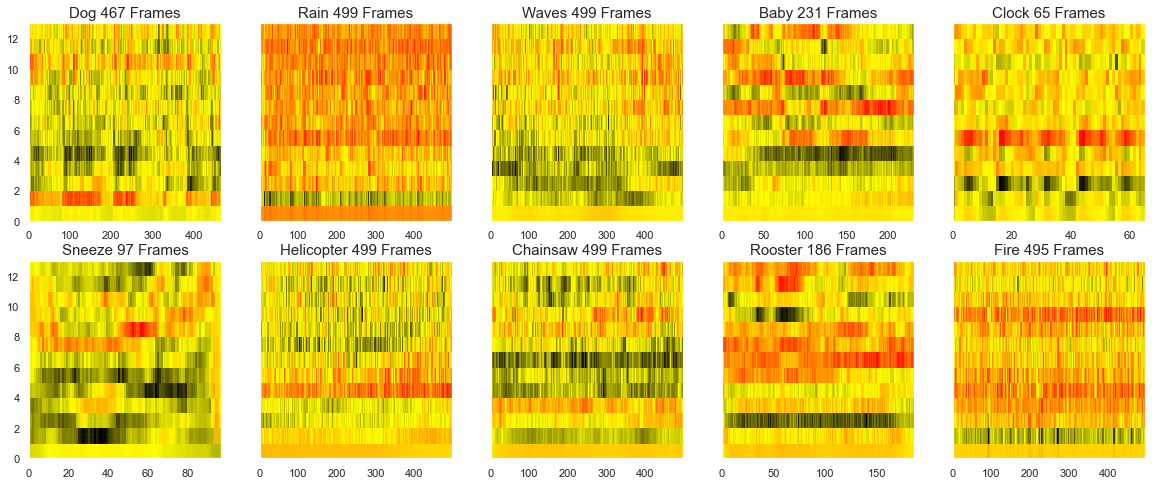

In [16]:
fig4, ax4= plt.subplots(2,5,figsize=(20,8),sharey=True)

clip=0

cvals  = [-50, 0, 50]
norm=plt.Normalize(min(cvals),max(cvals))
tuples = list(zip(map(norm,cvals), colors))
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", tuples)

for ro in [0,1]:
    for col in [0,1,2,3,4]:
        
        signal, samplerate = lb.load(random_clips_cleaned[clip][0],sr=16000)
        
        clip_duration=int(len(signal)/samplerate)
        clip_length=len(signal)
                
        mel=mfcc(signal,samplerate,winlen=0.025,winstep=0.01,nfilt=26,nfft=512).T
        num_frames=mel.shape[1]
        
        ax4[ro,col].pcolormesh(mel,cmap=cmap)
        ax4[ro,col].set_title(random_clips[clip][1]+' '+str(num_frames)+' Frames',fontsize=15)
        clip+=1

# 2.1 Generate the Dataset

We noticed that after cleaning the audio files, we lost quite a bit of the clips , specifically for samples that are bursty in nature ( e.g. sneeze, dog-bark ). <br> We now split the entire collection of audio files into a training set and validation set and have a look at the class wise duration for each class.

In [17]:
train_set=df[df['Test_Val']=='Test']
train_set.reset_index(inplace=True)
train_set=train_set.drop('index',axis=1)

val_set=df[df['Test_Val']=='Val']
val_set.reset_index(inplace=True)
val_set=val_set.drop('index',axis=1)

Text(0.5, 1.0, 'Duration of Validation Set Classes')

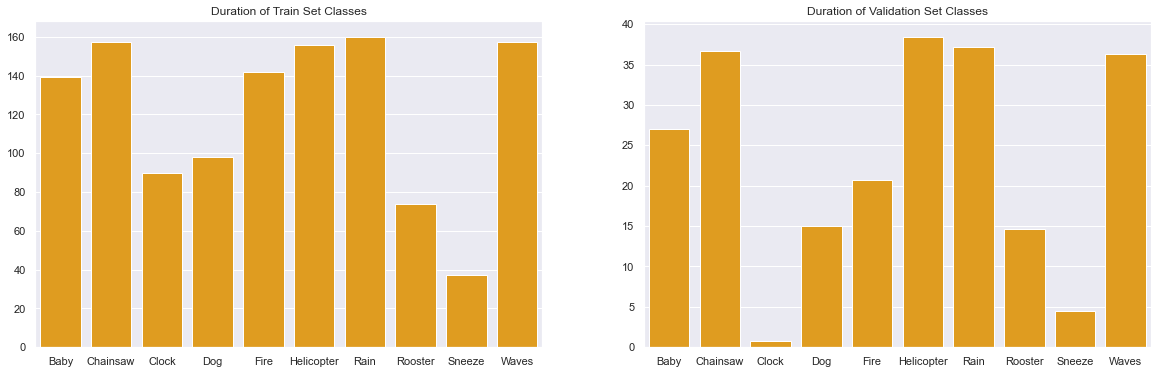

In [18]:
fig5, ax5= plt.subplots(1,2,figsize=(20,6),sharey=False,sharex=False)

x=list(train_set.groupby('Class')['Duration'].sum().index)
y=list(train_set.groupby('Class')['Duration'].sum())
sns.barplot(x=x, y=y,color='orange',ax=ax5[0])
ax5[0].set_title("Duration of Train Set Classes")

x=list(val_set.groupby('Class')['Duration'].sum().index)
y=list(val_set.groupby('Class')['Duration'].sum())
sns.barplot(x=x, y=y,color='orange',ax=ax5[1])
ax5[1].set_title("Duration of Validation Set Classes")

To generate the train and validation set, we take 100ms samples at random locations from the training set files. For the validation set , we only take the first 100ms from the files. 

In [19]:
val_set

,Files,Labels,Class,Test_Val,Clean File,Duration
0,C:\Users\Arindam\Documents\Up_Grad\Research\ES...,0,Dog,Val,5-203128-A.ogg,1.355170
1,C:\Users\Arindam\Documents\Up_Grad\Research\ES...,0,Dog,Val,5-203128-B.ogg,2.484150
2,C:\Users\Arindam\Documents\Up_Grad\Research\ES...,0,Dog,Val,5-208030-A.ogg,3.209546
3,C:\Users\Arindam\Documents\Up_Grad\Research\ES...,0,Dog,Val,5-212454-A.ogg,1.973991
4,C:\Users\Arindam\Documents\Up_Grad\Research\ES...,0,Dog,Val,5-213855-A.ogg,1.711293
...,...,...,...,...,...,...
66,C:\Users\Arindam\Documents\Up_Grad\Research\ES...,9,Fire,Val,5-186924-A.ogg,5.000998
67,C:\Users\Arindam\Documents\Up_Grad\Research\ES...,9,Fire,Val,5-189212-A.ogg,3.157256
68,C:\Users\Arindam\Documents\Up_Grad\Research\ES...,9,Fire,Val,5-213802-A.ogg,5.000998
69,C:\Users\Arindam\Documents\Up_Grad\Research\ES...,9,Fire,Val,5-215658-A.ogg,2.571655


In [25]:
path

'C:\\Users\\Arindam\\Documents\\Up_Grad\\Research'

In [20]:
X=[]
y=[]

samples=0
for i in tqdm(range(0,train_set.shape[0])):
    
    file=train_set.at[i,'Clean File']
    label=train_set.at[i,'Labels']
    
    signal,rate=lb.load(path+'\\Clean Files\\'+file,mono=False,sr=16000)
    j=signal.shape[0]
    frames=framesig(signal[:j-1600], frame_len=1600, frame_step=200)
    
    for i in range(0,frames.shape[0]):
        
        mel=mfcc(frames[i],16000,winlen=0.025,numcep=13,winstep=0.01,nfilt=26,nfft=512,winfunc=np.hamming)
        X.append(mel.T)
        y.append(label)
        samples+=1
        
y_train=np.zeros([samples,10])
y_train[np.arange(np.array(y).size),np.array(y)]=1
X_train=np.array(X)

100%|████████████████████████████████████████████████████████████████████████████████| 320/320 [03:24<00:00,  1.56it/s]


In [21]:
X=[]
y=[]

samples=0
for i in tqdm(range(0,val_set.shape[0])):
    
    file=val_set.at[i,'Clean File']
    label=val_set.at[i,'Labels']
    
    signal,rate=lb.load(path+'\\Clean Files\\'+file,mono=False,sr=16000)
    j=signal.shape[0]
    #frames=framesig(signal[:j-1600], frame_len=1600, frame_step=400)
    
    #for i in range(0,frames.shape[0]):
        
    mel=mfcc(signal[0:1600],16000,winlen=0.025,numcep=13,winstep=0.01,nfilt=26,nfft=512,winfunc=np.hamming)
    X.append(mel.T)
    y.append(label)
    samples+=1
        
y_val=np.zeros([samples,10])
y_val[np.arange(np.array(y).size),np.array(y)]=1
X_val=np.array(X)

100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:12<00:00,  5.85it/s]


In [22]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(92274, 13, 9)
(92274, 10)
(71, 13, 9)
(71, 10)


In [23]:
_min=X_train.min()
_max=X_train.max()


#X_train=(X_train-X_min)/(X_max-X_min)
#X_val=(X_val-X_min)/(X_max-X_min)


X_train=(X_train-_min)/(_max-_min)
X_val=(X_val-_min)/(_max-_min)

np.savez_compressed('Training Data 200.npz',name1=X_train,name2=y_train)
np.savez_compressed('Validation Data 200.npz',name1=X_val,name2=y_val)

In [24]:
print(_min)
print(_max)

-139.07223718198665
111.03934803755175
